In [215]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [216]:
y = np.random.randint(0,3,500)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 182
1 175
2 143


In [217]:
x = np.zeros((500,))

In [218]:
np.random.seed(12)
x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))

In [219]:
x[idx[0]][0], x[idx[2]][5] 

(-0.8458371576203276, 2.5977516640696616)

In [220]:
print(x.shape,y.shape)

(500,) (500,)


In [221]:
idx= []
for i in range(3):
  idx.append(y==i)

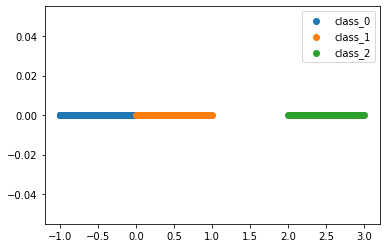

In [222]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [223]:
bg_idx = [ np.where(idx[2] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(143,)

In [224]:
np.unique(bg_idx).shape

(143,)

In [225]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [226]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([1.4906491e-16]), array([-1.81456605]))

In [227]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [228]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([1.]), array([4.26256846]))

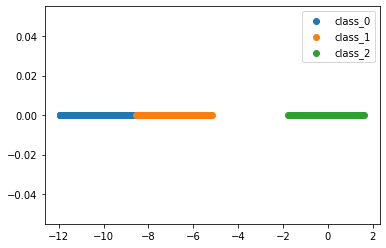

In [229]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [230]:
foreground_classes = {'class_0','class_1' }

background_classes = {'class_2'}

In [231]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,3)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 2 present at 0
background 2 present at 1
background 2 present at 2
background 2 present at 3
background 2 present at 4
background 2 present at 5
background 2 present at 6
background 2 present at 7
foreground 1 present at 8
(9,)
1 8


In [232]:
a.shape

(9,)

In [233]:
np.reshape(a,(9,1))

array([[ 0.40979192],
       [-0.04565917],
       [-0.77031028],
       [ 1.08379709],
       [ 0.22227256],
       [-0.43434573],
       [ 1.00020239],
       [ 0.22227256],
       [-6.28320936]])

In [234]:
a=np.reshape(a,(3,3))

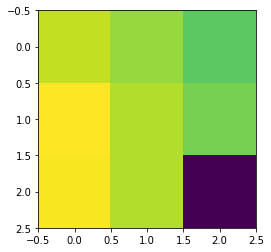

In [235]:
plt.imshow(a)

In [236]:
desired_num = 2000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,2)
    fg_idx = 0
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(9,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [237]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [238]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((2000, 9), array([-10.68799918,   0.94030013,   0.7524408 ,  -0.95760213,
         -0.43434573,   0.31742836,   1.35464187,   0.58432   ,
         -1.19055412]))

In [239]:
for j in range(9):
  print(mosaic_list_of_images[0][j])
  

-10.687999184729621
0.9403001287685366
0.7524408023240402
-0.9576021280224775
-0.43434572784995695
0.3174283630550014
1.354641873345945
0.5843200010524233
-1.1905541245396298


In [240]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.array([0,0,0,0,0,0,0,0,0])
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([1], dtype=torch.float64)
    np.random.seed(int(dataset_number*10000 + i))
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(9):
      if j == give_pref:
        img = img + mosaic_dataset[i][j]*dataset_number/9   #2 is data dim
      else :
        img = img + mosaic_dataset[i][j]*(9-dataset_number)/(8*9)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index
        
  

In [241]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0.2)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0.4)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0.6)
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0.8)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1.2)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1.4)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1.6)
avg_image_dataset_10 , labels_10,  fg_index_10 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1.8)

test_dataset , labels , fg_index = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[1000:2000], mosaic_label[1000:2000], fore_idx[1000:2000] , 9)

number of correct averaging happened for dataset 0 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 0.2 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 0.4 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 0.6 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 0.8 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 1 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 1.2 is 1000
the averaging are done as  [1000    0    0    0    0    0    0    0    0]
number of correct averaging happened for dataset 1.4 is 100

In [242]:
avg = torch.stack(avg_image_dataset_1, axis = 0)
avg_image_dataset_1 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_1, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_1, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_2, axis = 0)
avg_image_dataset_2 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_2, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_2, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_3, axis = 0)
avg_image_dataset_3 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_3, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_3, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_4, axis = 0)
avg_image_dataset_4 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_4, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_4, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_5, axis = 0)
avg_image_dataset_5 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_5, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_5, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_6, axis = 0)
avg_image_dataset_6 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_6, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_6, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_7, axis = 0)
avg_image_dataset_7 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_7, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_7, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_8, axis = 0)
avg_image_dataset_8 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_8, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_8, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_9, axis = 0)
avg_image_dataset_9 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_9, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_9, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(avg_image_dataset_10, axis = 0)
avg_image_dataset_10 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(avg_image_dataset_10, keepdims= True, axis = 0))
print(torch.std(avg_image_dataset_10, keepdims= True, axis = 0))
print("=="*40)

avg = torch.stack(test_dataset, axis = 0)
test_dataset = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
print(torch.mean(test_dataset, keepdims= True, axis = 0))
print(torch.std(test_dataset, keepdims= True, axis = 0))
print("=="*40)


tensor([[3.7303e-17]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)
tensor([[-5.1514e-17]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)
tensor([[-7.1054e-18]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)
tensor([[2.3803e-16]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)
tensor([[2.3181e-16]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)
tensor([[-1.6520e-16]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)
tensor([[1.3944e-16]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)
tensor([[2.8422e-17]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)
tensor([[8.1712e-17]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)
tensor([[-1.9096e-17]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)
tensor([[5.2935e-16]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64)


Text(0.5, 1.0, 'type 2 alpha = 2/9')

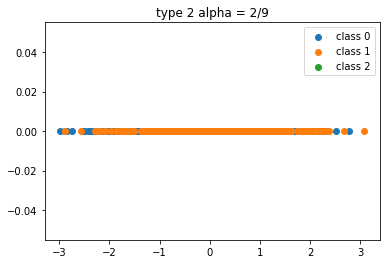

In [243]:
x1 = (avg_image_dataset_3).numpy()
y1 = np.array(labels_3)

# idx1 = []
# for i in range(3):
#   idx1.append(y1 == i)

# for i in range(3):
#     z = np.zeros(x1[idx1[i]].shape[0])
#     plt.scatter(x1[idx1[i]],z,label="class_"+str(i))
# plt.legend()

plt.scatter(x1[y1==0], y1[y1==0]*0, label='class 0')
plt.scatter(x1[y1==1], y1[y1==1]*0, label='class 1')
plt.scatter(x1[y1==2], y1[y1==2]*0, label='class 2')
plt.legend()
plt.title("type 2 alpha = 2/9")

Text(0.5, 1.0, 'type 2 alpha = 5/9')

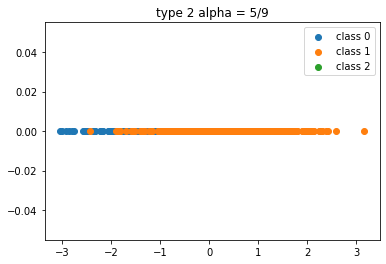

In [244]:
x1 = (avg_image_dataset_6).numpy()
y1 = np.array(labels_6)

# idx1 = []
# for i in range(3):
#   idx1.append(y1 == i)

# for i in range(3):
#     z = np.zeros(x1[idx1[i]].shape[0])
#     plt.scatter(x1[idx1[i]],z,label="class_"+str(i))
# plt.legend()
plt.scatter(x1[y1==0], y1[y1==0]*0, label='class 0')
plt.scatter(x1[y1==1], y1[y1==1]*0, label='class 1')
plt.scatter(x1[y1==2], y1[y1==2]*0, label='class 2')
plt.legend()
plt.title("type 2 alpha = 5/9")

Text(0.5, 1.0, 'type 2 alpha = 8/9')

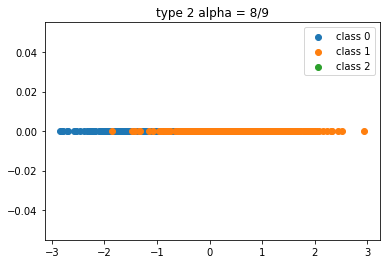

In [245]:
x1 = (avg_image_dataset_9).numpy()
y1 = np.array(labels_9)

# idx1 = []
# for i in range(3):
#   idx1.append(y1 == i)

# for i in range(3):
#     z = np.zeros(x1[idx1[i]].shape[0])
#     plt.scatter(x1[idx1[i]],z,label="class_"+str(i))
# plt.legend()

plt.scatter(x1[y1==0], y1[y1==0]*0, label='class 0')
plt.scatter(x1[y1==1], y1[y1==1]*0, label='class 1')
plt.scatter(x1[y1==2], y1[y1==2]*0, label='class 2')
plt.legend()
plt.title("type 2 alpha = 8/9")

Text(0.5, 1.0, 'type 2 alpha = 9/9')

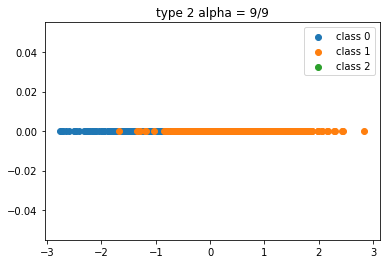

In [246]:
x1 = (avg_image_dataset_10).numpy()
y1 = np.array(labels_10)

plt.scatter(x1[y1==0], y1[y1==0]*0, label='class 0')
plt.scatter(x1[y1==1], y1[y1==1]*0, label='class 1')
plt.scatter(x1[y1==2], y1[y1==2]*0, label='class 2')
plt.legend()
plt.title("type 2 alpha = 9/9")

In [247]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [248]:
avg_image_dataset_1[0].shape
avg_image_dataset_1[0]

tensor([0.4880], dtype=torch.float64)

In [249]:
l = [ labels_1, labels_2, labels_3, labels_4, labels_5, labels_6, labels_7, labels_8, labels_9, labels_10]
for i in l:
  print(np.unique(l))

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [250]:
batch = 200

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)

traindata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
trainloader_10 = DataLoader( traindata_10 , batch_size= batch ,shuffle=True)

In [251]:
testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)



In [252]:
testdata_11 = MosaicDataset(test_dataset, labels )
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [253]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(1,50)
        self.linear2 = nn.Linear(50,10)
        self.linear3 = nn.Linear(10,3)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = (self.linear3(x))

        return x

In [254]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/i

In [255]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the 1000 test dataset %d: %.2f %%' % (number , 100 * correct / total))

In [256]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=0.001 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%500 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 1000 train images: %.2f %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi
    

In [257]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10, testloader_11]

In [258]:
train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))
train_loss_all.append(train_all(trainloader_10, 10, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
epoch: [0 ] loss: 1.369
epoch: [1] loss: 1.293
epoch: [501] loss: 0.861
Finished Training
Accuracy of the network on the 1000 train images: 54.50 %
unique out:  [0 1] unique pred:  [0 1]
correct:  545 total  1000
Accuracy of the network on the 1000 test dataset 1: 54.50 %
unique out:  [0 1] unique pred:  [0 1]
correct:  517 total  1000
Accuracy of the network on the 1000 test dataset 2: 51.70 %
unique out:  [0 1] unique pred:  [0 1]
correct:  493 total  1000
Accuracy of the network on the 1000 test dataset 3: 49.30 %
unique out:  [0 1] unique pred:  [0 1]
correct:  467 total  1000
Accuracy of the network on the 1000 test dataset 4: 46.70 %
unique out:  [0 1] unique pred:  [0 1]
correct:  446 total  1000
Accuracy of the network on the 1000 test dataset 5: 44.60 %
unique out:  [0 1] unique pred:  [0 1]
correct:  434 total  1000
Accuracy of the network on the 1000 test dataset 6: 43.4

In [259]:
%matplotlib inline

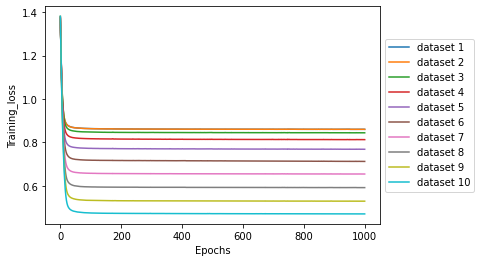

In [260]:
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))